In [1]:
import pandas as pd
import lasio
import os
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.interpolate as magic
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit

In [614]:
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import mean_squared_error as mse

In [2]:
parent_path = str(Path.joinpath(Path(os.getcwd()).parent))

well_data_path = parent_path + '/Well Data/'
seismic_data_path = parent_path + '/Seismic Data/'

In [3]:
def walk_path(path, fileformat):
    files=[]
    for root, dirs, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('.'+fileformat) and not filename.startswith('.'):           
                files.append(os.path.join(root,filename))
    return files

In [4]:
las_files = walk_path(well_data_path, 'las')
las_files

['/app/NVGd Contest/Well Data/35_8_2/NPHI.las',
 '/app/NVGd Contest/Well Data/35_8_2/CAL.las',
 '/app/NVGd Contest/Well Data/35_8_2/GR.las',
 '/app/NVGd Contest/Well Data/35_8_2/DT.las',
 '/app/NVGd Contest/Well Data/35_8_2/RHOB.las',
 '/app/NVGd Contest/Well Data/35_8_1/NPHI.las',
 '/app/NVGd Contest/Well Data/35_8_1/CAL.las',
 '/app/NVGd Contest/Well Data/35_8_1/GR.las',
 '/app/NVGd Contest/Well Data/35_8_1/DT.las',
 '/app/NVGd Contest/Well Data/35_8_1/RHOB.las',
 '/app/NVGd Contest/Well Data/35_8_3/NPHI.las',
 '/app/NVGd Contest/Well Data/35_8_3/GR.las',
 '/app/NVGd Contest/Well Data/35_8_3/DT.las',
 '/app/NVGd Contest/Well Data/35_8_3/RHOB.las']

In [5]:
well_list = set(i.split('/')[-2] for i in las_files)
print(well_list) 

{'35_8_2', '35_8_3', '35_8_1'}


In [6]:
w = '35_8_2'

def create_logs_df(well_name):
    df_list = pd.DataFrame()

    for lasfile in las_files:
        if lasfile.split('/')[-2] == well_name:
            las = lasio.read(lasfile)
            lasdf = las.df()   
            lasdf['DEPTH_discr'] = lasdf.index
            lasdf['DEPTH_discr'] = lasdf['DEPTH_discr'].round(1)
            lasdf = lasdf.set_index('DEPTH_discr')
            df_list = pd.concat([df_list,lasdf], axis=1)
        #df_list['WELL'] = w
        #df_list['HDEPTH'] = df_list.index
    return df_list.sort_index()
        

In [7]:
common_columns = ['HGR', 'HRHOB', 'HDT', 'HNPHI', 'HDEPTH']

In [8]:
workingdf = create_logs_df(w)

# Processing

<AxesSubplot:>

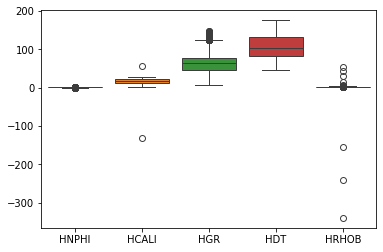

In [9]:
sns.boxplot(data=workingdf)

In [10]:
workingdf[workingdf.HRHOB>3.2] = float("NaN")
workingdf[workingdf.HRHOB<1.2] = float("NaN")

workingdf[workingdf.HCALI<0] = float("NaN")
workingdf[workingdf.HGR<0] = float("NaN")
workingdf[workingdf['HNPHI']<0]= float("NaN")

<AxesSubplot:>

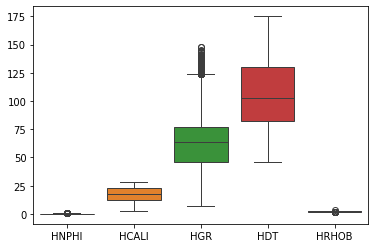

In [11]:
sns.boxplot(data=workingdf)

In [14]:
workingdf

,HNPHI,HCALI,HGR,HDT,HRHOB
DEPTH_discr,,,,,
381.8,NaN,NaN,13.4375,57.1250,NaN
382.0,NaN,NaN,15.8904,56.8750,NaN
382.1,NaN,NaN,15.8893,56.7501,NaN
382.3,NaN,NaN,17.7032,56.8744,NaN
382.4,NaN,NaN,20.1500,56.7508,NaN
...,...,...,...,...,...
4355.9,NaN,NaN,76.8125,71.3750,NaN
4356.0,NaN,NaN,76.8125,71.3750,NaN
4356.2,NaN,NaN,76.8125,71.3750,NaN


In [17]:
workingdf = workingdf[workingdf.index>2400]
workingdf = workingdf[workingdf.index<3980]
workingdf

,HNPHI,HCALI,HGR,HDT,HRHOB
DEPTH_discr,,,,,
2400.1,0.2677,25.0811,88.8918,106.3898,2.4250
2400.2,0.2769,NaN,87.0113,108.6726,NaN
2400.3,NaN,25.0301,NaN,NaN,2.4256
2400.4,0.2931,25.0073,83.8117,107.1818,2.4326
2400.5,0.3113,NaN,76.3291,106.5166,NaN
...,...,...,...,...,...
3979.5,0.1705,5.7657,68.8434,72.0853,2.6070
3979.6,0.1726,NaN,NaN,NaN,NaN
3979.7,NaN,5.7656,73.8256,72.5577,2.6138


In [18]:
def curve_track(curve, dataset):
    ztop=dataset.index.min()
    zbot=dataset.index.max()
    curve_left = dataset[curve].min()
    curve_right = dataset[curve].max()

    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 20))
    #ax.plot(workingdf.RHOB_synt_dt, workingdf.index, 'g', label = 'Syntetic from dt')
    ax.plot(dataset[curve], dataset.index, '-m', label = curve)

    ax.set_ylim(ztop,zbot)
    ax.invert_yaxis()
    ax.grid()  
    ax.set_xlabel(curve)
    ax.set_xlim(curve_left,curve_right)
    ax.legend()

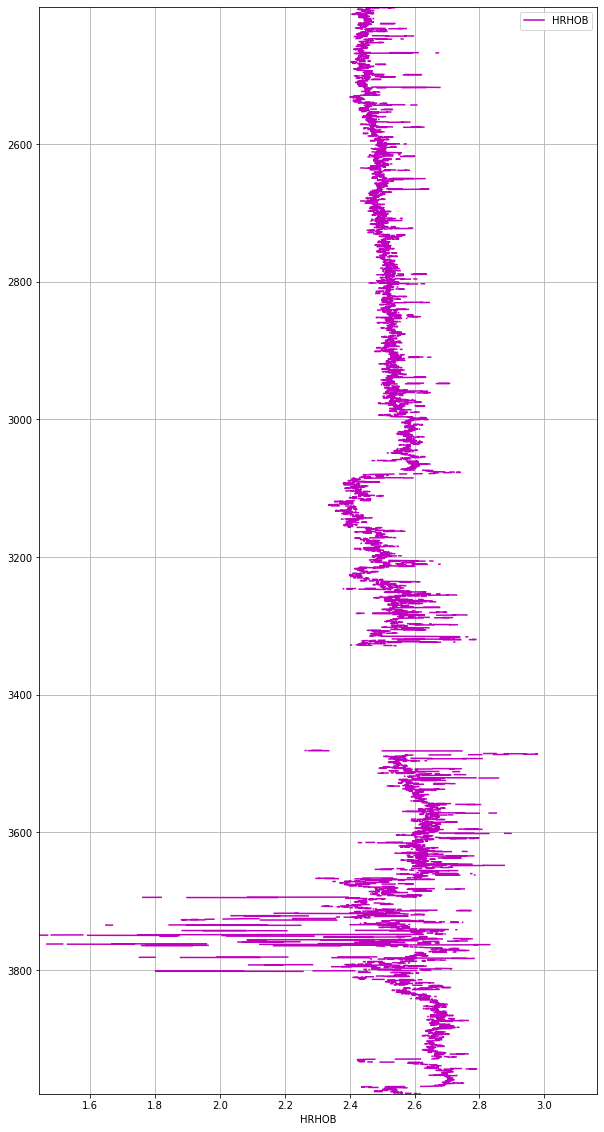

In [21]:
curve_track('HRHOB', workingdf)

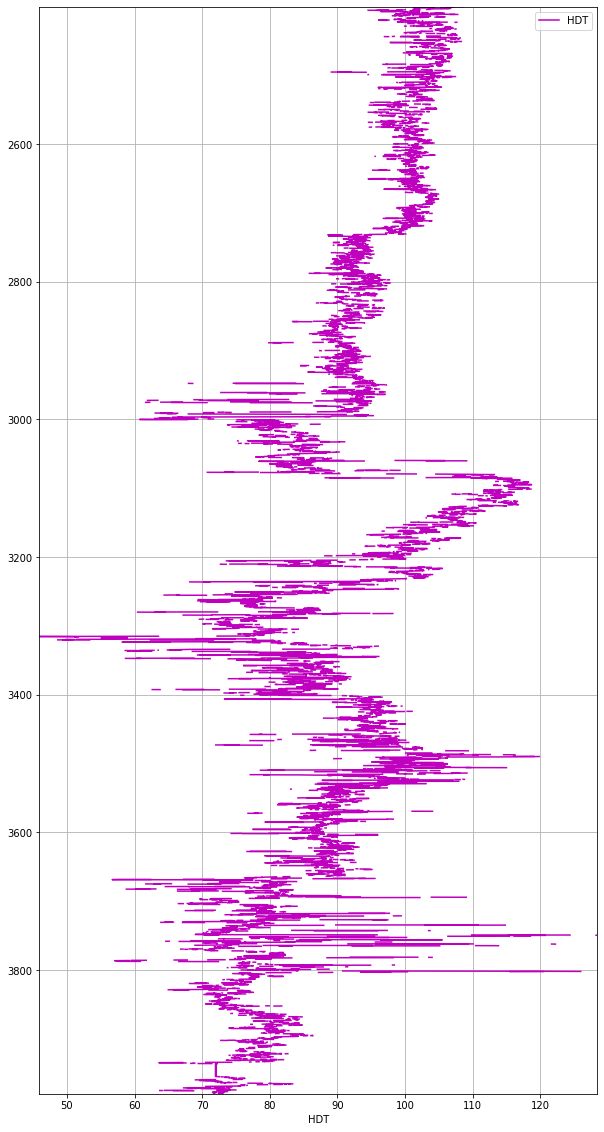

In [20]:
curve_track('HDT', workingdf)

### добавить попытки сгладить сигнал

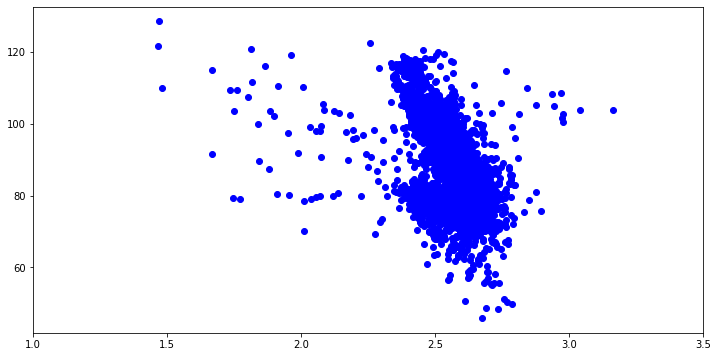

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))

x = final.index
y = final.HDT
z = final.HRHOB

ax.scatter(z,y, color='blue', label='Sonic wave')


plt.xlim([1,3.5])
plt.show()

In [58]:
def func_dt(x, a, b):
    return a*x+b

In [59]:
dropna__dt_to_rhob_df = final[['HRHOB','HDT']].dropna()
dropna__dt_to_rhob_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 6000 entries, 2400.1 to 3979.8
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HRHOB   6000 non-null   float64
 1   HDT     6000 non-null   float64
dtypes: float64(2)
memory usage: 140.6 KB


In [60]:
x = dropna__dt_to_rhob_df.HDT
z = dropna__dt_to_rhob_df.HRHOB

In [61]:
popt, pcov = curve_fit(func_dt, xdata = x, ydata = z, p0=[1,1])

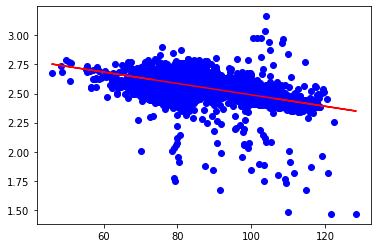

In [62]:
plt.scatter(x,z, color='blue')
plt.plot(x, func_dt(x, *popt), 'r-')

In [66]:
final['RHOB_synt_dt'] = np.clip((popt[0]*final.HDT+popt[1]), 1.5, 2.95)

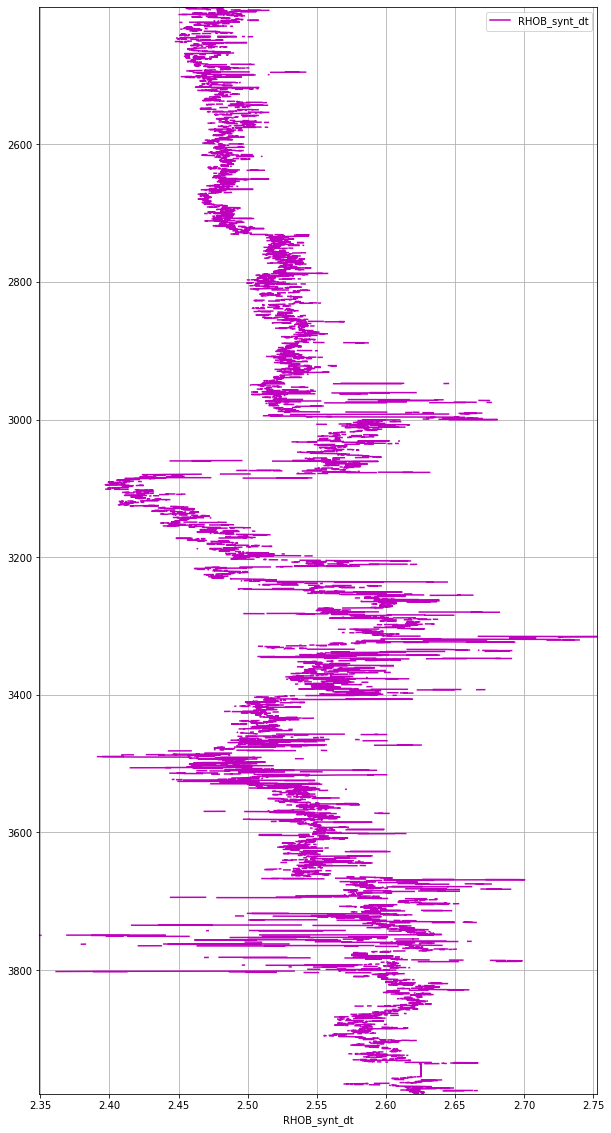

In [67]:
curve_track('RHOB_synt_dt', final)

# Create Mud Weight curve

In [22]:
csv_files = walk_path(well_data_path, 'csv')
csv_files

['/app/NVGd Contest/Well Data/35_8_2/MWL.csv']

In [23]:
mw_df = pd.read_csv(csv_files[0], sep = ';', decimal = ',', index_col = 'Depth')
len(mw_df)

19

In [24]:
y_interpol = magic.interp1d(mw_df.index, mw_df['MudWeight'])

In [26]:
mud_weight = pd.DataFrame()
mud_weight['Depth'] = workingdf.index
mud_weight = mud_weight.query("Depth > 2400")
mud_weight = mud_weight.query("Depth < 3980")
mud_weight['MW_int'] = [y_interpol(d).round(3) for d in mud_weight['Depth']]
mud_weight = mud_weight.set_index('Depth')
mud_weight

,MW_int
Depth,
2400.1,1.22
2400.2,1.22
2400.3,1.22
2400.4,1.22
2400.5,1.22
...,...
3979.5,1.70
3979.6,1.70
3979.7,1.70


In [28]:
from pathlib import Path
parent_path = str(Path.joinpath(Path(os.getcwd()).parent))
data_path = parent_path + '/Data/'
mud_weight.to_excel(data_path+'35_8-2_MW.xlsx', engine = 'xlsxwriter')

In [34]:
final = workingdf.merge(mud_weight, left_on = workingdf.index, right_on = mud_weight.index, how = 'inner')

In [35]:
final = final.rename({'key_0': 'Depth'}, axis='columns')
final = final.set_index('Depth')
final

,HNPHI,HCALI,HGR,HDT,HRHOB,MW_int
Depth,,,,,,
2400.1,0.2677,25.0811,88.8918,106.3898,2.4250,1.22
2400.2,0.2769,NaN,87.0113,108.6726,NaN,1.22
2400.3,NaN,25.0301,NaN,NaN,2.4256,1.22
2400.4,0.2931,25.0073,83.8117,107.1818,2.4326,1.22
2400.5,0.3113,NaN,76.3291,106.5166,NaN,1.22
...,...,...,...,...,...,...
3979.5,0.1705,5.7657,68.8434,72.0853,2.6070,1.70
3979.6,0.1726,NaN,NaN,NaN,NaN,1.70
3979.7,NaN,5.7656,73.8256,72.5577,2.6138,1.70


In [27]:
lim_dict = {
    'HGR':[0,150],
    'HDT':[150, 30],
    'HRHOB':[1.85, 2.85],
    'HNPHI':[0.6, 0],
    'HCALI':[5, 20],
    'MW_int':[1,2],
}

In [29]:
def create_plot_adv(final, a): 
    lim_dict = {
        'HGR':[0,150],
        'HDT':[150, 30],
        'HRHOB':[1.85, 2.85],
        'HNPHI':[0.6, 0],
        'HCALI':[5, 20],
        'MW_int':[1,2],
        'HDEPTH':[1,2],
        'WELL':[1,2],
    }
    ztop=final.index.min()
    zbot=final.index.max()

    ncol = len(final.columns)
    f, ax = plt.subplots(nrows=1, ncols=ncol, figsize=(10, 12))
    for i, log in enumerate(final.columns):
        ax[i].plot(final[log], final.index, color = np.random.rand(3,))

    for i in range(len(ax)):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()  
    for i, log in enumerate(final.columns):
        ax[i].set_xlabel(str(log))
        if a > 5:
            ax[i].set_xlim(lim_dict[log][0],lim_dict[log][1])
        else:
            ax[i].set_xlim(final[log].min(),final[log].max())

In [32]:
def create_plot(final,ztop, zbot):    

    ncol = len(final.columns)
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(10, 12))
    ax[0].plot(final.HGR, final.index, 'r')
    ax[1].plot(final.HRHOB, final.index, '-m')
    ax[2].plot(final.HDT, final.index, '-', color='c')
    ax[3].plot(final.HNPHI, final.index, '-.', color='b')
    ax[4].plot(final.MW_int, final.index, '-', color='r')
    ax[5].plot(final.HCALI, final.index, '-', color='c')

    for i in range(len(ax)):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()  
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(final.HGR.min(),final.HGR.max())
    ax[1].set_xlabel("Density")
    ax[1].set_xlim(final.HRHOB.min(),final.HRHOB.max())
    ax[2].set_xlabel("Acoustic")
    ax[2].set_xlim(final.HDT.min(),final.HDT.max())
    ax[3].set_xlabel("Neutron Porosity")
    ax[3].set_xlim(final.HNPHI.min(),final.HNPHI.max())
    ax[4].set_xlabel("Mud Weight")
    ax[4].set_xlim(final.MW_int.min(),final.MW_int.max())
    ax[5].set_xlabel("Caliper")
    ax[5].set_xlim(0,60)

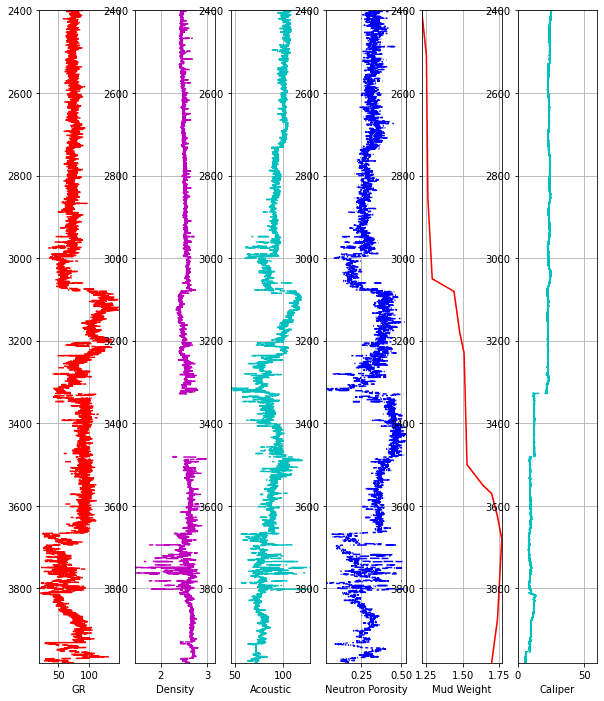

In [37]:
create_plot(final, 2400, 3980)

# Syntetic curves

In [348]:
ggkp_min = final.HRHOB.quantile(0.005)
ggkp_max = final.HRHOB.quantile(0.99)
print(ggkp_min, ggkp_max)

2.0097375 2.7426


In [39]:
gr_min = final.HGR.quantile(0.1)
gr_max = final.HGR.quantile(0.95)
print(gr_min, gr_max)

53.573299999999996 113.29192000000002


In [46]:
final['dgr'] = np.clip(((final.HGR-gr_min)/(gr_max-gr_min)), 0, 1)
final['dgr'].describe()

count    10379.000000
mean         0.415303
std          0.275057
min          0.000000
25%          0.236819
50%          0.377452
75%          0.605865
max          1.000000
Name: dgr, dtype: float64

In [47]:
final['Kp'] = np.clip((final.HNPHI - final.dgr*0.3), 0, 0.5)

In [48]:
final['RHOB_synt_nphi'] = ggkp_max - (final.HNPHI*(ggkp_max-ggkp_min))
final['RHOB_synt_nphi_cor'] = ggkp_max - (final['Kp']*(ggkp_max-ggkp_min))

In [51]:
def initial_vs_syntetic(final, a, b):
    ztop=final.index.min()
    zbot=final.index.max()

    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 20))
    ax.plot(final[b], final.index, 'g', label = 'Syntetic')
    ax.plot(final[a], final.index, '-m', label = 'Initial')
    ax.plot(final.MW_int, final.index, '-', color='r')

    ax.set_ylim(ztop,zbot)
    ax.invert_yaxis()
    ax.grid()  
    #ax.set_xlabel("Density")
    ax.set_xlim(lim_dict[a])
    ax.legend()

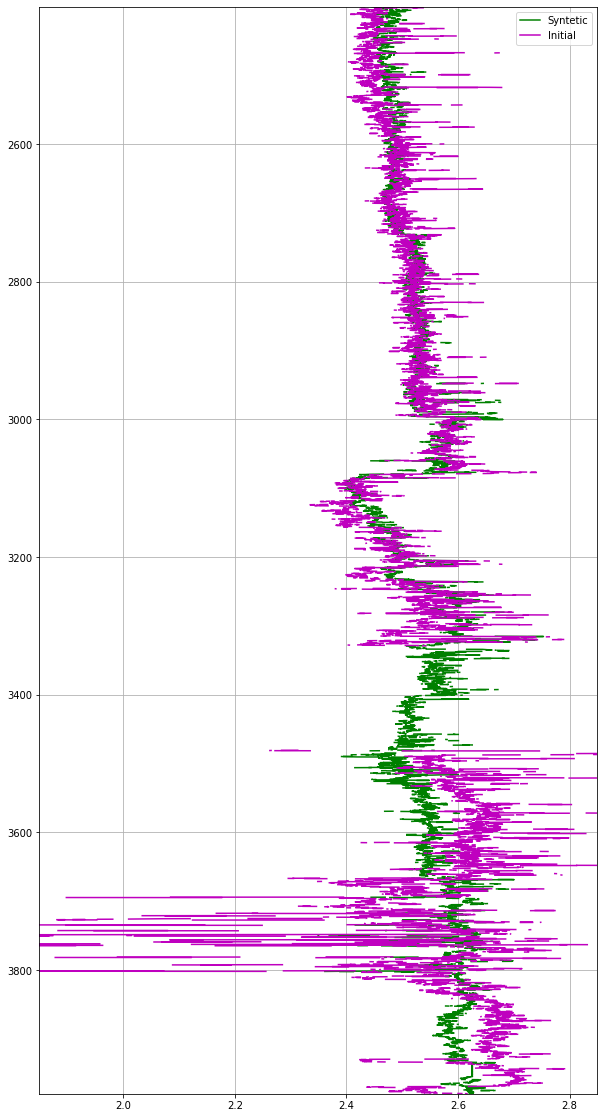

In [68]:
initial_vs_syntetic(final, 'HRHOB', 'RHOB_synt_dt')

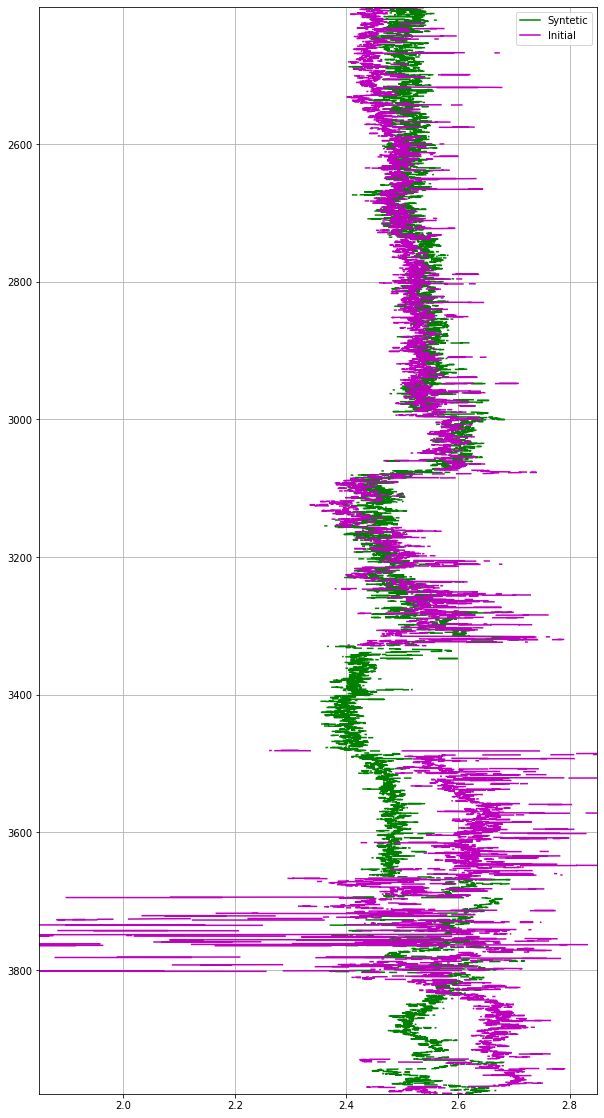

In [53]:
initial_vs_syntetic(final, 'HRHOB', 'RHOB_synt_nphi')

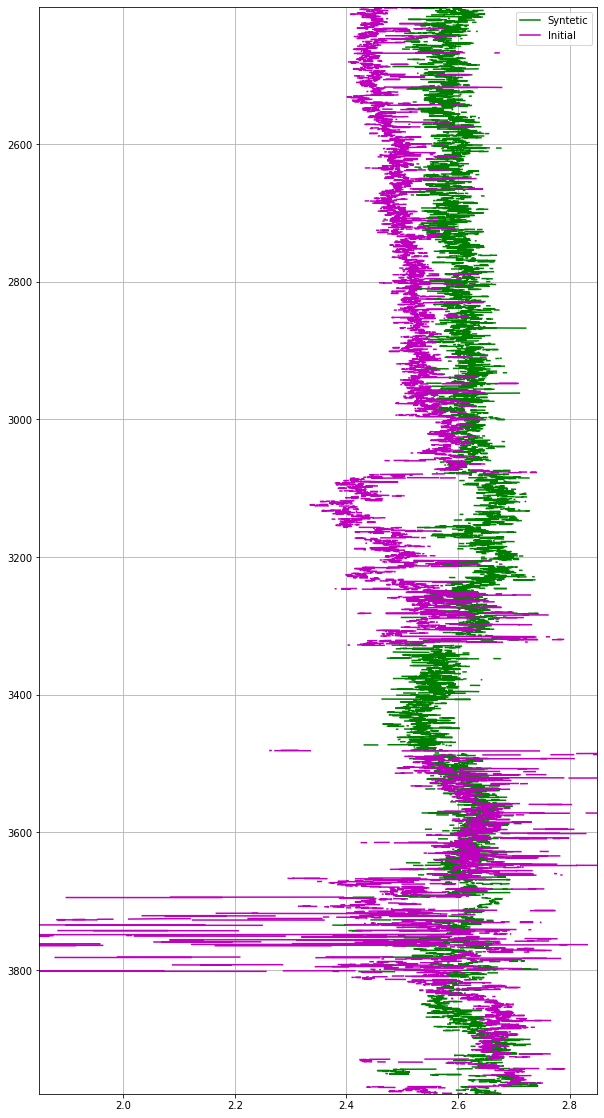

In [55]:
initial_vs_syntetic(final, 'HRHOB', 'RHOB_synt_nphi_cor')

In [456]:
w = '35_8_3'
workingdf3 = create_logs_df(w)
workingdf3

,HNPHI,HGR,HDT,HRHOB
DEPTH_discr,,,,
390.5,NaN,10.2578,129.3750,NaN
390.6,NaN,7.5314,52.0054,NaN
390.8,NaN,6.9844,51.9978,NaN
391.0,NaN,6.4329,52.0000,NaN
391.1,NaN,9.6283,52.0000,NaN
...,...,...,...,...
3962.4,0.3009,NaN,NaN,2.5766
3962.6,0.3009,NaN,NaN,2.5683
3962.7,0.3009,NaN,NaN,2.5620


In [464]:
w = '35_8_1'
workingdf1 = create_logs_df(w)
workingdf1

,HNPHI,HCALI,HGR,HDT,HRHOB
DEPTH_discr,,,,,
404.5,NaN,NaN,-0.2044,NaN,NaN
404.7,NaN,NaN,-0.2356,NaN,NaN
404.8,NaN,NaN,-0.2670,NaN,NaN
405.0,NaN,NaN,-0.2982,NaN,NaN
405.1,NaN,NaN,-0.3296,NaN,NaN
...,...,...,...,...,...
4354.5,NaN,7.4882,NaN,NaN,2.4395
4354.6,0.2114,NaN,NaN,NaN,NaN
4354.7,0.2114,7.4883,NaN,NaN,2.4395


## Distribution

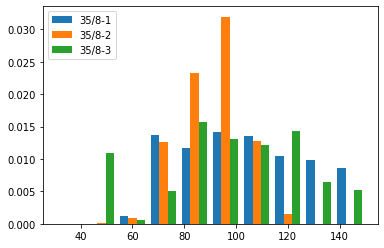

In [465]:
log = 'HDT'

plt.hist([workingdf1[log], workingdf[log], workingdf3[log]], 
        label =['35/8-1', '35/8-2', '35/8-3'], range = (min(lim_dict[log]),max(lim_dict[log])), density=True)
plt.legend(prop ={'size': 10}, loc = 'upper left')


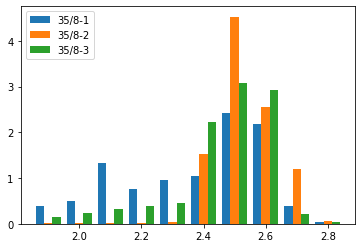

In [466]:
log = 'HRHOB'

plt.hist([workingdf1[log], workingdf[log], workingdf3[log]], 
        label =['35/8-1', '35/8-2', '35/8-3'], range = (min(lim_dict[log]),max(lim_dict[log])), density=True)
plt.legend(prop ={'size': 10}, loc = 'upper left')

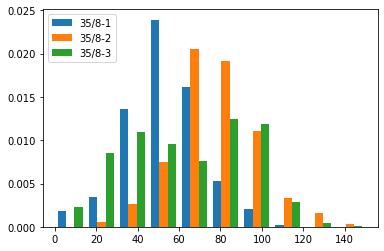

In [467]:
log = 'HGR'

plt.hist([workingdf1[log], workingdf[log], workingdf3[log]], 
        label =['35/8-1', '35/8-2', '35/8-3'], range = (min(lim_dict[log]),max(lim_dict[log])), density=True)
plt.legend(prop ={'size': 10}, loc = 'upper left')

In [468]:
final['Phyd'] = 9.78*1405*(final.index+381)
final[final.index==3312]

,HNPHI,HCALI,HGR,HDT,HRHOB,MW_int,dgr,Kp,RHOB_synt_nphi,RHOB_synt_nphi_cor,RHOB_synt_dt,Phyd,Phyd_psi,Phyd_psi_MW
Depth,,,,,,,,,,,,,,
3312.0,NaN,21.8943,NaN,NaN,2.4731,1.516,NaN,NaN,NaN,NaN,NaN,50745143.7,7359.957954,7941.420824


In [469]:
final['Phyd_psi'] = 9.78*1405*(final.index+381) /6894.76
final[final.index==3312]

,HNPHI,HCALI,HGR,HDT,HRHOB,MW_int,dgr,Kp,RHOB_synt_nphi,RHOB_synt_nphi_cor,RHOB_synt_dt,Phyd,Phyd_psi,Phyd_psi_MW
Depth,,,,,,,,,,,,,,
3312.0,NaN,21.8943,NaN,NaN,2.4731,1.516,NaN,NaN,NaN,NaN,NaN,50745143.7,7359.957954,7941.420824


In [470]:
final['Phyd_psi_MW'] = 9.78*final.MW_int*1000*(final.index+381) /6894.76
final[final.index==3312]

,HNPHI,HCALI,HGR,HDT,HRHOB,MW_int,dgr,Kp,RHOB_synt_nphi,RHOB_synt_nphi_cor,RHOB_synt_dt,Phyd,Phyd_psi,Phyd_psi_MW
Depth,,,,,,,,,,,,,,
3312.0,NaN,21.8943,NaN,NaN,2.4731,1.516,NaN,NaN,NaN,NaN,NaN,50745143.7,7359.957954,7941.420824


In [471]:
#velocity_depth law

In [472]:
twt_files = walk_path(well_data_path, 'txt')
twt_files

['/app/NVGd Contest/Well Data/35_8_2/time-depth.txt',
 '/app/NVGd Contest/Well Data/35_8_1/time-depth.txt',
 '/app/NVGd Contest/Well Data/35_8_3/time-depth.txt']

In [473]:
twt_dict = {}
for i in twt_files:
    twt = pd.read_csv(i, sep='\t', decimal = '.', header=None, names=['Depth', 'Time'])
    twt_dict[i.split('/')[-2]]=np.array(twt)
    
twt_dict

{'35_8_2': array([[2.60000e+01, 0.00000e+00],
        [3.10000e+01, 6.77000e-03],
        [3.60000e+01, 1.35400e-02],
        ...,
        [4.31100e+03, 3.43204e+00],
        [4.31600e+03, 3.43445e+00],
        [4.32063e+03, 3.43674e+00]]),
 '35_8_1': array([[2.6000e+01, 0.0000e+00],
        [8.2600e+02, 9.0280e-01],
        [1.4060e+03, 1.4496e+00],
        [1.7060e+03, 1.6916e+00],
        [1.7360e+03, 1.7216e+00],
        [1.7660e+03, 1.7456e+00],
        [1.7960e+03, 1.7716e+00],
        [1.8260e+03, 1.7996e+00],
        [1.8560e+03, 1.8278e+00],
        [1.8860e+03, 1.8538e+00],
        [1.9160e+03, 1.8718e+00],
        [1.9460e+03, 1.9058e+00],
        [1.9760e+03, 1.9278e+00],
        [2.0060e+03, 1.9498e+00],
        [2.0360e+03, 1.9738e+00],
        [2.0660e+03, 1.9958e+00],
        [2.0960e+03, 2.0238e+00],
        [2.1260e+03, 2.0478e+00],
        [2.1560e+03, 2.0678e+00],
        [2.1860e+03, 2.0918e+00],
        [2.2160e+03, 2.1158e+00],
        [2.2460e+03, 2.1398e+00],
 

In [474]:
A = twt_dict['35_8_2']
A = pd.DataFrame(A, columns=['Depth', 'Time'])
A['Velocity'] = (A.Depth*2)/A.Time 
A.Depth = A.Depth.round(1)
A

,Depth,Time,Velocity
0,26.0,0.00000,inf
1,31.0,0.00677,9158.050222
2,36.0,0.01354,5317.577548
3,41.0,0.02030,4039.408867
4,46.0,0.02707,3398.596232
...,...,...,...
855,4301.0,3.42718,2509.935282
856,4306.0,3.42958,2511.094653
857,4311.0,3.43204,2512.208482
858,4316.0,3.43445,2513.357306


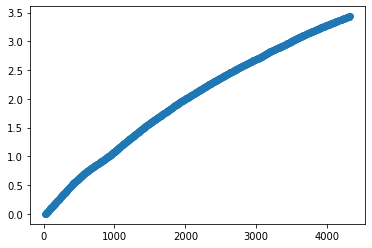

In [475]:
plt.scatter(A['Depth'], A['Time'])

In [476]:
B = twt_dict['35_8_1']
B = pd.DataFrame(B, columns=['Depth', 'Time'])
B['Velocity'] = (B.Depth*2)/B.Time 
B.Depth = B.Depth.round(1)
B

,Depth,Time,Velocity
0,26.0,0.0000,inf
1,826.0,0.9028,1829.862650
2,1406.0,1.4496,1939.845475
3,1706.0,1.6916,2017.025301
4,1736.0,1.7216,2016.728625
...,...,...,...
87,4226.0,3.3620,2513.979774
88,4256.0,3.3720,2524.317912
89,4286.0,3.3820,2534.594914
90,4318.0,3.4100,2532.551320


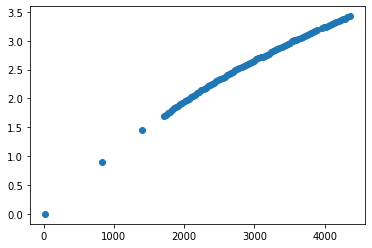

In [477]:
plt.scatter(B['Depth'], B['Time'])

In [478]:
C = twt_dict['35_8_3']
C = pd.DataFrame(C, columns=['Depth', 'Time'])
C['Velocity'] = (C.Depth*2)/C.Time 
C.Depth = C.Depth.round(1)
C

,Depth,Time,Velocity
0,23.0,0.00000,inf
1,28.0,0.00661,8472.012103
2,33.0,0.01321,4996.214989
3,38.0,0.01982,3834.510595
4,43.0,0.02643,3253.878169
...,...,...,...
782,3927.2,3.19364,2459.362358
783,3932.0,3.19644,2460.258913
784,3936.9,3.19920,2461.184046
785,3941.8,3.20179,2462.238935


In [479]:
def vel_depth_law(x, a, b):
    return a*x**b

In [480]:
popt3, pcov3 = curve_fit(vel_depth_law, xdata = A['Time'], ydata = A['Depth'], p0=[100,1])

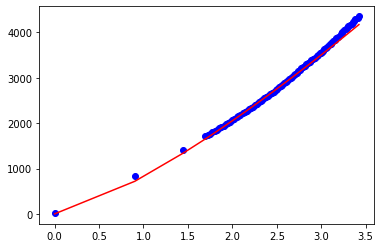

In [481]:
plt.scatter(B['Time'], B['Depth'], color='blue')
plt.plot(B['Time'], vel_depth_law(B['Time'], *popt3), 'r-')

In [482]:
well_seism_data = final.merge(A, left_on = final.index, right_on = A.Depth, how = 'inner')
#well_seism_data = well_seism_data.drop(['Depth_x', 'Depth_y'], axis=1)
#well_seism_data = well_seism_data.rename({'key_0': 'Depth'}, axis='columns')

well_seism_data = well_seism_data.set_index('Depth')
well_seism_data

,key_0,HNPHI,HCALI,HGR,HDT,HRHOB,MW_int,dgr,Kp,RHOB_synt_nphi,RHOB_synt_nphi_cor,RHOB_synt_dt,Phyd,Phyd_psi,Phyd_psi_MW,Time,Velocity
Depth,,,,,,,,,,,,,,,,,
2401.0,2401.0,0.3317,25.0375,72.0814,102.1104,2.5276,1.220,0.309922,0.238723,2.499510,2.567649,2.478216,38227183.8,5544.382081,4814.338889,2.29608,2091.390544
2406.0,2406.0,0.3369,24.9937,80.3891,101.1342,2.4720,1.220,0.449036,0.202189,2.495699,2.594423,2.482997,38295888.3,5554.346823,4822.991547,2.29954,2092.592432
2411.0,2411.0,0.2823,24.8832,82.3012,103.0743,2.4136,1.220,0.481054,0.137984,2.535713,2.641477,2.473496,38364592.8,5564.311564,4831.644205,2.30297,2093.817983
2416.0,2416.0,0.2999,NaN,75.9244,101.2860,NaN,1.222,0.374274,0.187618,2.522815,2.605102,2.482254,38433297.3,5574.276305,4848.231776,2.30646,2094.985389
2421.0,2421.0,0.2869,NaN,76.2178,102.0043,NaN,1.223,0.379187,0.173144,2.532342,2.615709,2.478736,38502001.8,5584.241047,4860.873167,2.30984,2096.249091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956.0,3956.0,NaN,6.2661,NaN,NaN,2.7055,1.709,NaN,NaN,NaN,NaN,NaN,59594283.3,8643.416638,10513.593619,3.25947,2427.388502
3961.0,3961.0,NaN,6.2410,76.2173,70.1822,2.7110,1.707,0.379178,NaN,NaN,NaN,2.634574,59662987.8,8653.381379,10513.396452,3.26198,2428.586319
3966.0,3966.0,0.3249,5.9459,115.3881,82.3543,2.6940,1.705,1.000000,0.024900,2.504493,2.724352,2.574965,59731692.3,8663.346121,10513.170915,3.26458,2429.715308


In [483]:
well_seism_data = well_seism_data.drop(['key_0'], axis=1)

In [484]:
well_seism_data

,HNPHI,HCALI,HGR,HDT,HRHOB,MW_int,dgr,Kp,RHOB_synt_nphi,RHOB_synt_nphi_cor,RHOB_synt_dt,Phyd,Phyd_psi,Phyd_psi_MW,Time,Velocity
Depth,,,,,,,,,,,,,,,,
2401.0,0.3317,25.0375,72.0814,102.1104,2.5276,1.220,0.309922,0.238723,2.499510,2.567649,2.478216,38227183.8,5544.382081,4814.338889,2.29608,2091.390544
2406.0,0.3369,24.9937,80.3891,101.1342,2.4720,1.220,0.449036,0.202189,2.495699,2.594423,2.482997,38295888.3,5554.346823,4822.991547,2.29954,2092.592432
2411.0,0.2823,24.8832,82.3012,103.0743,2.4136,1.220,0.481054,0.137984,2.535713,2.641477,2.473496,38364592.8,5564.311564,4831.644205,2.30297,2093.817983
2416.0,0.2999,NaN,75.9244,101.2860,NaN,1.222,0.374274,0.187618,2.522815,2.605102,2.482254,38433297.3,5574.276305,4848.231776,2.30646,2094.985389
2421.0,0.2869,NaN,76.2178,102.0043,NaN,1.223,0.379187,0.173144,2.532342,2.615709,2.478736,38502001.8,5584.241047,4860.873167,2.30984,2096.249091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956.0,NaN,6.2661,NaN,NaN,2.7055,1.709,NaN,NaN,NaN,NaN,NaN,59594283.3,8643.416638,10513.593619,3.25947,2427.388502
3961.0,NaN,6.2410,76.2173,70.1822,2.7110,1.707,0.379178,NaN,NaN,NaN,2.634574,59662987.8,8653.381379,10513.396452,3.26198,2428.586319
3966.0,0.3249,5.9459,115.3881,82.3543,2.6940,1.705,1.000000,0.024900,2.504493,2.724352,2.574965,59731692.3,8663.346121,10513.170915,3.26458,2429.715308


In [485]:
def func(x, a, b):
    return a*x**b

In [486]:
dropna_df = well_seism_data.dropna()
x=dropna_df['Velocity']
y=dropna_df['HRHOB']

In [487]:
popt4, pcov4 = curve_fit(func, x, y, p0=[1,1])

In [488]:
well_seism_data['p_gard'] = popt4[0]*well_seism_data['Velocity']**popt4[1]

In [489]:
well_seism_data['p_gard']

Depth
2401.0    2.464419
2406.0    2.464953
2411.0    2.465497
2416.0    2.466015
2421.0    2.466576
            ...   
3956.0    2.606777
3961.0    2.607262
3966.0    2.607719
3971.0    2.608175
3976.0    2.608687
Name: p_gard, Length: 299, dtype: float64

(1.8, 2.85)

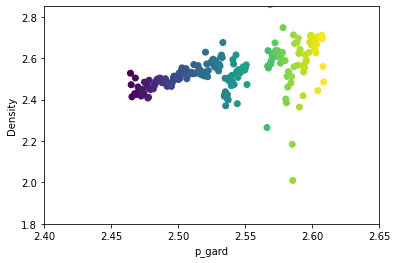

In [490]:
x=well_seism_data['p_gard']
y=well_seism_data['HRHOB']
c = well_seism_data.index

plt.scatter(x, y, c=c)
plt.xlabel("p_gard")
plt.ylabel("Density")


plt.xlim(2.4, 2.65)
plt.ylim(1.8, 2.85)

In [491]:
formations_dict = {"KYRRE":[2089, 2947], 
              "TRYGGVASON": [2947, 3059],
              "RØDBY": [3060, 3074],
              "ÅSGARD": [3074, 3079],
              "DRAUPNE": [3079, 3204],
              "HEATHER": [3204, 3666],
              "TARBERT": [3666, 3786],
              "NESS": [3717, 3786],
              "ETIVE": [3786, 3814],
              "RANNOCH": [3814, 3868],
              "BROOM": [3868, 3885],
              "DRAKE": [3885, 3932],
              "COOK": [3932, 4064],
              "BURTON": [4064, 4095],
              "AMUNDSEN": [4095, 4203]
             }

In [492]:
well_seism_data['Depth'] = well_seism_data.index
mw_pred_df = well_seism_data[['Depth', 'MW_int', 'Velocity', 'Time', 'HDT']]

In [493]:
def vnormfunc(x, a,b):
    return a+b*x

In [494]:
d = mw_pred_df.Depth
p = mw_pred_df.Velocity

In [495]:
popt5, pcov5 = curve_fit(vnormfunc, d, p, p0=[1000,1])

In [496]:
mw_pred_df['V_normal'] = popt5[0]+(popt5[1])*mw_pred_df['Depth']
mw_pred_df[['V_normal', 'Velocity']]

/tmp/ipykernel_15121/2139085836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mw_pred_df['V_normal'] = popt5[0]+(popt5[1])*mw_pred_df['Depth']


,V_normal,Velocity
Depth,,
2401.0,2096.487056,2091.390544
2406.0,2097.553263,2092.592432
2411.0,2098.619470,2093.817983
2416.0,2099.685678,2094.985389
2421.0,2100.751885,2096.249091
...,...,...
3956.0,2428.077490,2427.388502
3961.0,2429.143698,2428.586319
3966.0,2430.209905,2429.715308


(1500.0, 2500.0)

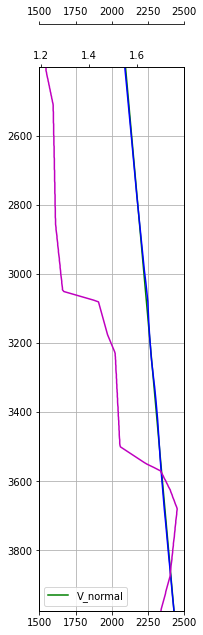

In [497]:
ztop=mw_pred_df.index.min()
zbot=mw_pred_df.index.max()
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))

#Set up the plot axes
ax1 = plt.subplot2grid((1,5), (0,0), rowspan=1, colspan = 1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()

ax2.spines["top"].set_position(("axes", 1.08))

ax1.plot(mw_pred_df['V_normal'], mw_pred_df.index, 'g', label = 'V_normal')
ax2.plot(mw_pred_df.Velocity, mw_pred_df.index, '-b', label = 'Cube Velocity')
ax3.plot(well_seism_data.MW_int, well_seism_data.index, '-m', label = 'Mud Weight')

#ax1.set_xlabel('Velocity')
ax1.set_ylim(ztop,zbot)
ax1.set_xlim(1500,2500)
ax1.grid()
ax1.legend()

ax1.invert_yaxis()
ax2.set_xlim(1500,2500)

In [498]:
well_seism_data['Overburden Pressure'] = 381*1000*9.8+9.8*1305*well_seism_data['p_gard']*well_seism_data['Depth']
well_seism_data['Overburden Pressure_psi'] = well_seism_data['Overburden Pressure']/6894.76
well_seism_data[['Overburden Pressure_psi', 'Phyd_psi']]

,Overburden Pressure_psi,Phyd_psi
Depth,,
2401.0,11517.039271,5544.382081
2406.0,11542.277389,5554.346823
2411.0,11567.571525,5564.311564
2416.0,11592.759249,5574.276305
2421.0,11618.147574,5584.241047
...,...,...
3956.0,19669.896921,8643.416638
3961.0,19697.635171,8653.381379
3966.0,19725.176483,8663.346121


In [499]:
import math
a = 20
b = 200
c = 0.0003
#0.000245
e = math.e

In [500]:
well_seism_data['dt_norm'] = a + (b-a)*e**(-c*well_seism_data['Depth'])

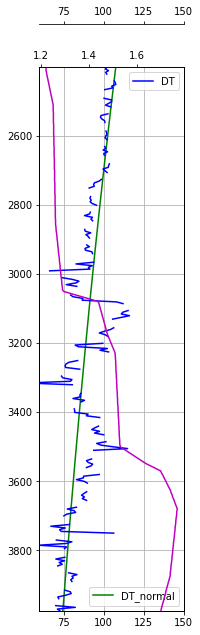

In [501]:
ztop=well_seism_data.index.min()
zbot=well_seism_data.index.max()
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))

#Set up the plot axes
ax1 = plt.subplot2grid((1,5), (0,0), rowspan=1, colspan = 1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()

ax2.spines["top"].set_position(("axes", 1.08))
ax2.set_xlim(60,150)

ax1.plot(well_seism_data['dt_norm'], well_seism_data.index, 'g', label = 'DT_normal')
ax2.plot(well_seism_data.HDT, well_seism_data.index, '-b', label = 'DT')
ax3.plot(well_seism_data.MW_int, well_seism_data.index, '-m', label = 'Mud Weight')

#ax1.set_xlabel('Velocity')
ax1.set_ylim(ztop,zbot)

ax1.grid()
ax1.legend()
ax2.legend()

ax1.set_xlim(60,150)
ax1.invert_yaxis()



In [502]:
well_seism_data['Eatons PP'] = well_seism_data['Overburden Pressure_psi'] - (well_seism_data['Overburden Pressure_psi'] -
                                                                       well_seism_data['Phyd_psi'])*((well_seism_data['dt_norm']/well_seism_data['HDT'])**0.5)

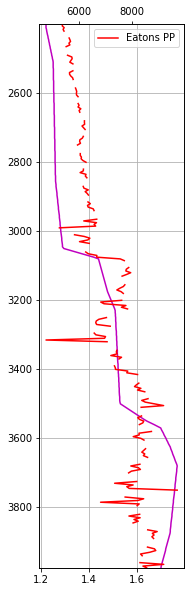

In [503]:
ztop=well_seism_data.index.min()
zbot=well_seism_data.index.max()
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))

#Set up the plot axes
ax1 = plt.subplot2grid((1,5), (0,0), rowspan=1, colspan = 1)
ax2 = ax1.twiny()

ax1.plot(well_seism_data['MW_int'], well_seism_data.index, 'm', label = 'MW')
ax2.plot(well_seism_data['Eatons PP'], well_seism_data.index, '-r', label = 'Eatons PP')

ax1.set_ylim(ztop,zbot)
ax1.grid()

ax1.invert_yaxis()
ax2.legend()

In [504]:
well_seism_data.HDT

Depth
2401.0    102.1104
2406.0    101.1342
2411.0    103.0743
2416.0    101.2860
2421.0    102.0043
            ...   
3956.0         NaN
3961.0     70.1822
3966.0     82.3543
3971.0     71.1711
3976.0     72.7373
Name: HDT, Length: 299, dtype: float64

In [505]:
well_seism_data['V_norm'] = (1/well_seism_data.HDT*1000000)*0.3048
well_seism_data[['Velocity','V_norm']]

,Velocity,V_norm
Depth,,
2401.0,2091.390544,2985.004466
2406.0,2092.592432,3013.817284
2411.0,2093.817983,2957.090177
2416.0,2094.985389,3009.300397
2421.0,2096.249091,2988.109325
...,...,...
3956.0,2427.388502,NaN
3961.0,2428.586319,4342.981554
3966.0,2429.715308,3701.081789


# Pore pressure prediction

In [506]:
def clean_df(workingdf):
    workingdf[workingdf.HRHOB>3.2] = float("NaN")
    workingdf[workingdf.HRHOB<1.2] = float("NaN")

    #workingdf[workingdf.HCALI<0] = float("NaN")
    workingdf[workingdf.HGR<0] = float("NaN")
    workingdf[workingdf['HNPHI']<0]= float("NaN")
    
    return workingdf

In [507]:
w = '35_8_1'
workingdf1 = create_logs_df(w)
workingdf1

,HNPHI,HCALI,HGR,HDT,HRHOB
DEPTH_discr,,,,,
404.5,NaN,NaN,-0.2044,NaN,NaN
404.7,NaN,NaN,-0.2356,NaN,NaN
404.8,NaN,NaN,-0.2670,NaN,NaN
405.0,NaN,NaN,-0.2982,NaN,NaN
405.1,NaN,NaN,-0.3296,NaN,NaN
...,...,...,...,...,...
4354.5,NaN,7.4882,NaN,NaN,2.4395
4354.6,0.2114,NaN,NaN,NaN,NaN
4354.7,0.2114,7.4883,NaN,NaN,2.4395


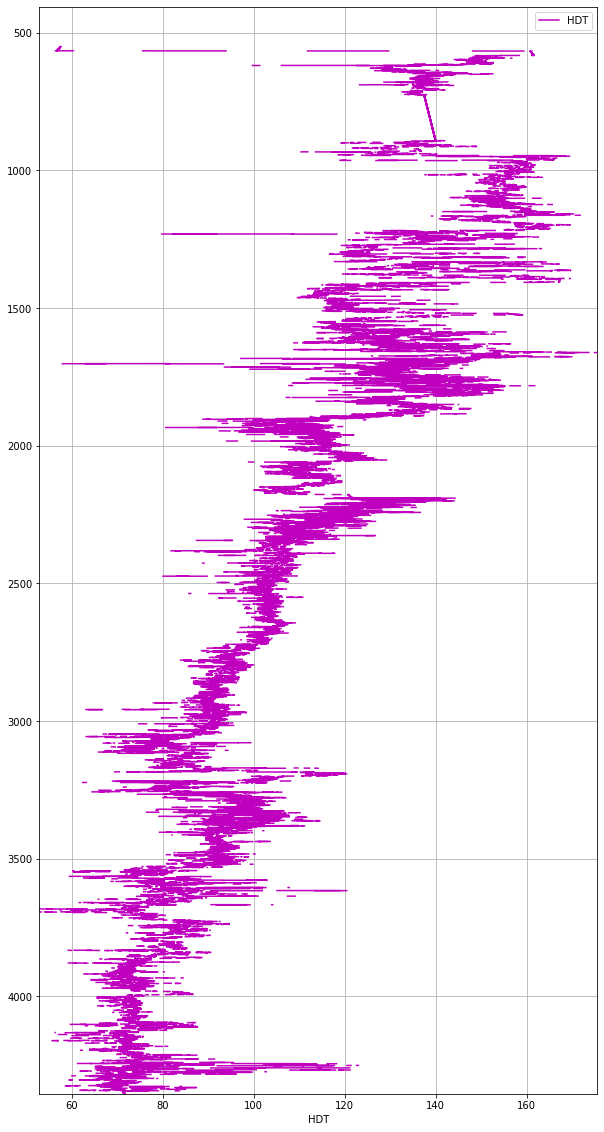

In [508]:
curve_track('HDT', workingdf1)

In [509]:
workingdf1 = clean_df(workingdf1)
workingdf3 = clean_df(workingdf3)

In [510]:
workingdf1['Phyd_psi'] = 9.78*1405*(workingdf1.index+381) /6894.76

In [511]:
workingdf3['Phyd_psi'] = 9.78*1405*(workingdf3.index+381) /6894.76

In [512]:
B

,Depth,Time,Velocity
0,26.0,0.0000,inf
1,826.0,0.9028,1829.862650
2,1406.0,1.4496,1939.845475
3,1706.0,1.6916,2017.025301
4,1736.0,1.7216,2016.728625
...,...,...,...
87,4226.0,3.3620,2513.979774
88,4256.0,3.3720,2524.317912
89,4286.0,3.3820,2534.594914
90,4318.0,3.4100,2532.551320


In [513]:
workingdf1 = workingdf1.merge(B, left_on = workingdf1.index, right_on = B.Depth, how = 'inner')
workingdf1

,key_0,HNPHI,HCALI,HGR,HDT,HRHOB,Phyd_psi,Depth,Time,Velocity
0,826.0,NaN,NaN,17.7419,NaN,NaN,2405.488559,826.0,0.9028,1829.862650
1,1406.0,NaN,17.3268,51.1496,164.7037,1.9349,3561.398555,1406.0,1.4496,1939.845475
2,1706.0,0.3803,NaN,NaN,135.4858,NaN,4159.283035,1706.0,1.6916,2017.025301
3,1736.0,NaN,17.6885,43.7795,124.2459,2.1358,4219.071483,1736.0,1.7216,2016.728625
4,1766.0,0.5129,17.3718,43.9244,NaN,2.0491,4278.859931,1766.0,1.7456,2023.373052
...,...,...,...,...,...,...,...,...,...,...
85,4196.0,0.1212,9.2793,32.7808,NaN,2.5579,9121.724222,4196.0,3.3480,2506.571087
86,4226.0,0.1756,NaN,NaN,75.6448,NaN,9181.512670,4226.0,3.3620,2513.979774
87,4256.0,NaN,8.7179,60.2686,73.6763,2.4398,9241.301119,4256.0,3.3720,2524.317912
88,4286.0,0.3517,9.0452,90.2165,NaN,2.6199,9301.089567,4286.0,3.3820,2534.594914


In [514]:
workingdf1 = workingdf1.drop(['key_0'], axis=1)
workingdf1 = workingdf1.set_index('Depth')
workingdf1

,HNPHI,HCALI,HGR,HDT,HRHOB,Phyd_psi,Time,Velocity
Depth,,,,,,,,
826.0,NaN,NaN,17.7419,NaN,NaN,2405.488559,0.9028,1829.862650
1406.0,NaN,17.3268,51.1496,164.7037,1.9349,3561.398555,1.4496,1939.845475
1706.0,0.3803,NaN,NaN,135.4858,NaN,4159.283035,1.6916,2017.025301
1736.0,NaN,17.6885,43.7795,124.2459,2.1358,4219.071483,1.7216,2016.728625
1766.0,0.5129,17.3718,43.9244,NaN,2.0491,4278.859931,1.7456,2023.373052
...,...,...,...,...,...,...,...,...
4196.0,0.1212,9.2793,32.7808,NaN,2.5579,9121.724222,3.3480,2506.571087
4226.0,0.1756,NaN,NaN,75.6448,NaN,9181.512670,3.3620,2513.979774
4256.0,NaN,8.7179,60.2686,73.6763,2.4398,9241.301119,3.3720,2524.317912


In [515]:
workingdf1['p_gard'] = popt4[0]*workingdf1['Velocity']**popt4[1]

In [516]:
workingdf1['Depth']=workingdf1.index

In [517]:
workingdf1['Overburden Pressure'] = 381*1000*9.8+9.8*1305*workingdf1['p_gard']*workingdf1['Depth']
workingdf1['Overburden Pressure_psi'] = workingdf1['Overburden Pressure']/6894.76

In [518]:
workingdf1['dt_norm'] = a + (b-a)*e**(-c*workingdf1['Depth'])

In [519]:
workingdf3 = workingdf3.merge(C, left_on = workingdf3.index, right_on = C.Depth, how = 'inner')
workingdf3 = workingdf3.drop(['key_0'], axis=1)
workingdf3 = workingdf3.set_index('Depth')
workingdf3

,HNPHI,HGR,HDT,HRHOB,Phyd_psi,Time,Velocity
Depth,,,,,,,
403.0,NaN,12.3729,52.0000,NaN,1562.471442,0.50004,1611.871050
408.0,NaN,13.5989,52.0000,NaN,1572.436183,0.50519,1615.233872
413.0,NaN,12.1023,52.0000,NaN,1582.400925,0.51034,1618.528824
418.0,NaN,11.2216,52.0000,NaN,1592.365666,0.51550,1621.726479
423.0,NaN,12.7084,52.0000,NaN,1602.330407,0.52065,1624.891962
...,...,...,...,...,...,...,...
3927.2,0.2709,78.8495,74.3397,2.6158,8586.019728,3.19364,2459.362358
3932.0,0.2154,NaN,NaN,2.6635,8595.585880,3.19644,2460.258913
3936.9,0.3266,NaN,NaN,2.6215,8605.351326,3.19920,2461.184046


In [520]:
workingdf3['p_gard'] = popt4[0]*workingdf3['Velocity']**popt4[1]

In [521]:
workingdf3['Depth']=workingdf3.index

In [522]:
workingdf3['Overburden Pressure'] = 381*1000*9.8+9.8*1305*workingdf3['p_gard']*workingdf3['Depth']
workingdf3['Overburden Pressure_psi'] = workingdf3['Overburden Pressure']/6894.76

In [523]:
workingdf3['dt_norm'] = a + (b-a)*e**(-c*workingdf3['Depth'])

In [524]:
workingdf1['Eatons PP'] = workingdf1['Overburden Pressure_psi'] - (workingdf1['Overburden Pressure_psi'] -
                                                                       workingdf1['Phyd_psi'])*((workingdf1['dt_norm']/workingdf1['HDT'])**0.5)

In [525]:
workingdf3['Eatons PP'] = workingdf3['Overburden Pressure_psi'] - (workingdf3['Overburden Pressure_psi'] -
                                                                       workingdf3['Phyd_psi'])*((workingdf3['dt_norm']/workingdf3['HDT'])**0.5)

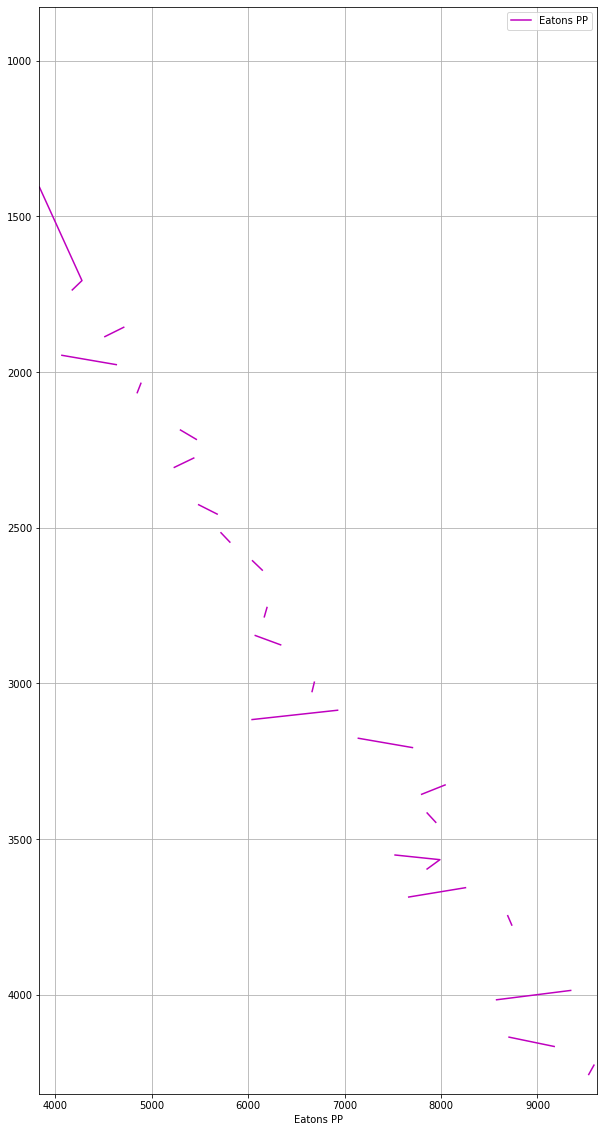

In [526]:
curve_track('Eatons PP', workingdf1)

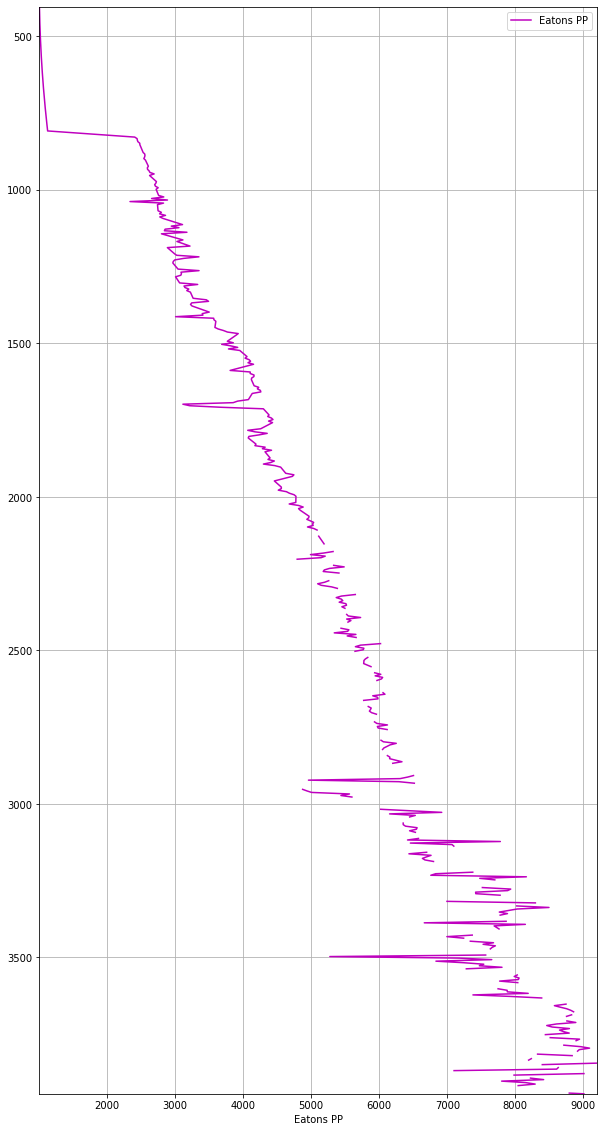

In [527]:
curve_track('Eatons PP', workingdf3)

In [528]:
workingdf3['Mud_weight'] = workingdf3['Eatons PP']/(1.24*workingdf3['Depth'])
workingdf3['Mud_weight'].dropna().tail(10)

Depth
3883.2    1.657411
3893.0    1.703410
3897.9    1.741220
3902.8    1.611373
3907.6    1.682231
3912.5    1.709076
3917.4    1.655505
3927.2    1.746851
3941.8    1.798912
3944.1    1.841684
Name: Mud_weight, dtype: float64

In [529]:
workingdf1['Mud_weight'] = workingdf1['Eatons PP']/(1.24*workingdf1['Depth'])
workingdf1['Mud_weight'].dropna().tail(10)

Depth
3836.0    1.719151
3896.0    1.686351
3986.0    1.890569
4016.0    1.722081
4076.0    1.766562
4136.0    1.697326
4166.0    1.775801
4226.0    1.829258
4256.0    1.806111
4318.0    1.797077
Name: Mud_weight, dtype: float64

In [596]:
well_seism_data['Mud_weight'] = well_seism_data['Eatons PP']/(1.24*well_seism_data['Depth'])

In [597]:
well_seism_data['Eatons PP']

Depth
2401.0    5386.244360
2406.0    5369.980781
2411.0    5441.727341
2416.0    5401.181511
2421.0    5436.369189
             ...     
3956.0            NaN
3961.0    8291.789530
3966.0    9184.953192
3971.0    8402.816461
3976.0    8541.573535
Name: Eatons PP, Length: 299, dtype: float64

In [598]:
well_seism_data['B_PP'] = well_seism_data['MW_int']*(1.24*well_seism_data['Depth'])
well_seism_data['B_PP']

Depth
2401.0    3632.23280
2406.0    3639.79680
2411.0    3647.36080
2416.0    3660.91648
2421.0    3671.49492
             ...    
3956.0    8383.39696
3961.0    8384.16948
3966.0    8384.91720
3971.0    8385.64012
3976.0    8391.26848
Name: B_PP, Length: 299, dtype: float64

In [599]:
pred = well_seism_data['Mud_weight']
target = well_seism_data['MW_int']

In [607]:
well_seism_data['Mud_weight_sm'] = pd.Series(well_seism_data['Mud_weight']).rolling(window = 10).mean().values

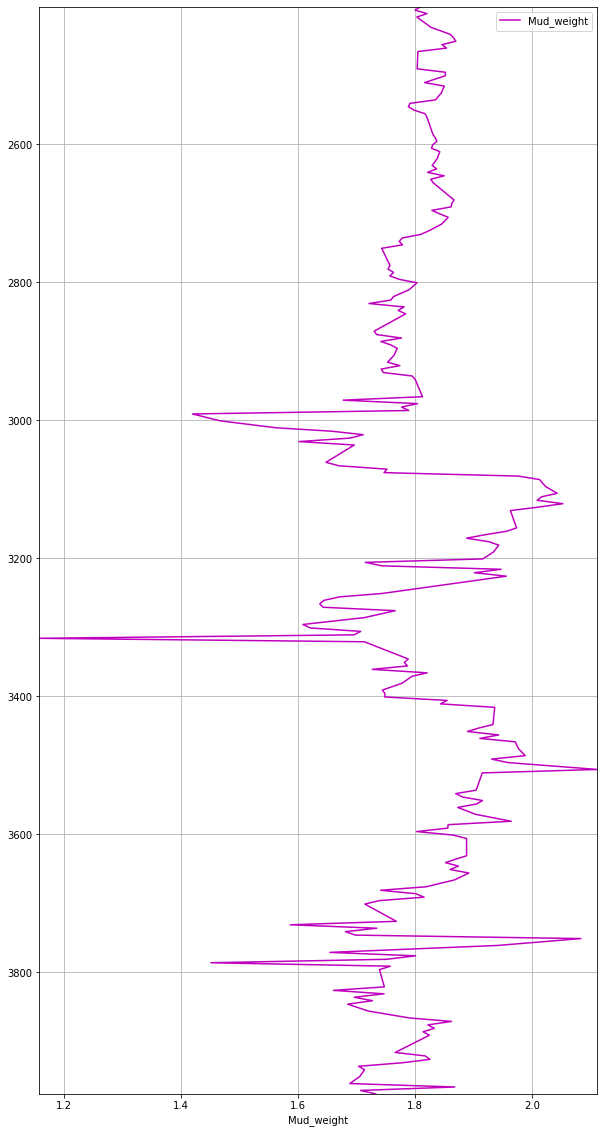

In [608]:
curve_track('Mud_weight', well_seism_data)

In [609]:
pred

Depth
2401.0    1.809140
2406.0    1.799929
2411.0    1.820195
2416.0    1.802894
2421.0    1.810892
            ...   
3956.0    1.696627
3961.0    1.688192
3966.0    1.867680
3971.0    1.706488
3976.0    1.732486
Name: Mud_weight, Length: 299, dtype: float64

In [610]:
pred2 = well_seism_data['Mud_weight_sm']

In [611]:
pred2

Depth
2401.0         NaN
2406.0         NaN
2411.0         NaN
2416.0         NaN
2421.0         NaN
            ...   
3956.0    1.757018
3961.0    1.746914
3966.0    1.755929
3971.0    1.749997
3976.0    1.741524
Name: Mud_weight_sm, Length: 299, dtype: float64

In [612]:
target

Depth
2401.0    1.220
2406.0    1.220
2411.0    1.220
2416.0    1.222
2421.0    1.223
          ...  
3956.0    1.709
3961.0    1.707
3966.0    1.705
3971.0    1.703
3976.0    1.702
Name: MW_int, Length: 299, dtype: float64

In [613]:
mask = np.isnan(pred)
mask2 = np.isnan(pred2)
pred[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), pred[~mask])
pred2[mask2] = np.interp(np.flatnonzero(mask2), np.flatnonzero(~mask2), pred2[~mask2])

In [615]:
MAE=mae(target, pred)
MAE

0.35353148772928256

In [616]:
MSE=mse(target, pred)
MSE

0.16660722632811273

In [617]:
MAE2=mae(target, pred2)
MAE2

0.3472145522445703

In [618]:
MSE2=mse(target, pred2)
MSE2

0.16257103706876547